# Predicting State Liquor Sales using Time Series
October 2016 <br>
Author: Peter Corniotes

##### Import Modules

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

##### Load Data and Create Time Series Index

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('/Users/petercorniotes/Downloads/Iowa_Liquor_Sales_reduced.csv', 
                 parse_dates=['Date'], index_col='Date', date_parser=dateparse, 
                 low_memory=False)
print df.index
print "df shape", df.shape
df.head(1)

DatetimeIndex(['2016-03-31', '2016-03-31', '2016-03-31', '2016-03-31',
               '2016-03-31', '2016-03-31', '2016-03-31', '2016-03-31',
               '2016-03-31', '2016-03-31',
               ...
               '2015-01-05', '2015-01-05', '2015-01-05', '2015-01-05',
               '2015-01-05', '2015-01-05', '2015-01-05', '2015-01-05',
               '2015-01-05', '2015-01-05'],
              dtype='datetime64[ns]', name=u'Date', length=2709552, freq=None)
df shape (2709552, 17)


,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
Date,,,,,,,,,,,,,,,,,
2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.5,1.19


##### Data Cleaning

In [3]:
#rename columns
df.columns = ['store', 'city', 'zip', 'cntynum', 'county', 'category', 'cat_name', 'vendor', 
              'itemnum', 'des', 'vol', 'cost', 'retail', 'sold', 'sales', 'liters', 'gallons']

#delete columns
del df['city']; del df['cntynum']; del df['category']; del df['cat_name']; del df['vendor']; 
del df['itemnum']; del df['des']; del df['vol']; del df['cost']; del df['retail']; 
del df['sold']; del df['liters']; del df['gallons']

#change sales field to float
df[['sales']] = df[['sales']].replace('[\$,]','',regex=True).astype(float)

print df.count()
print '\ndf shape', df.shape
df.head(3)

store     2709552
zip       2709552
county    2698639
sales     2709552
dtype: int64

df shape (2709552, 4)


,store,zip,county,sales
Date,,,,
2016-03-31,5029,52806,Scott,179.88
2016-03-31,5029,52806,Scott,37.50
2016-03-31,4959,50613,Black Hawk,53.76


In [4]:
#replace NaN with string
df.county.fillna('Missing County', inplace=True)
df.count()

store     2709552
zip       2709552
county    2709552
sales     2709552
dtype: int64

##### Sales by County for 5 quarters: Q1-2015 through Q1-2016


                             Sales by County Q1-2015 through Q1-2016 (5 quarters)


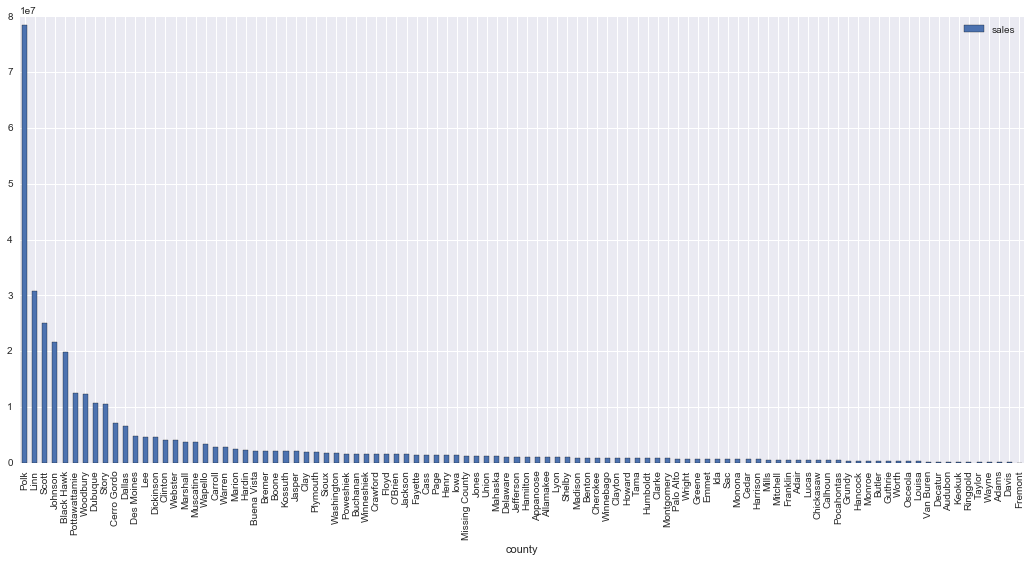

In [5]:
# use pivot table to get sales by county
county_sales = pd.pivot_table(df, index=['county'], values=['sales'], aggfunc=np.sum).\
sort_values('sales', ascending = False)
county_sales.plot(kind='bar', figsize=(18,8))
print "\n                             Sales by County Q1-2015 through Q1-2016 (5 quarters)"

In [6]:
county_sales.head(12)

,sales
county,
Polk,7.847391e+07
Linn,3.085593e+07
Scott,2.502894e+07
Johnson,2.156258e+07
Black Hawk,1.989110e+07
Pottawattamie,1.242305e+07
Woodbury,1.234449e+07
Dubuque,1.066283e+07
Story,1.059031e+07


##### Group By Daily Sales

In [7]:
df1 = df.groupby([df.index]).sales.agg(['sum'])
df1.columns = ['sales']
df1.head()

,sales
Date,
2015-01-05,1621501.80
2015-01-06,1149511.54
2015-01-07,1469466.12
2015-01-08,1019332.31
2015-01-12,1147093.19


##### Split Time Series Into Quarters

In [8]:
time_series = df1['sales']
Q1_2015 = time_series['2015-01-01':'2015-03-31']
Q2_2015 = time_series['2015-04-01':'2015-06-30']
Q3_2015 = time_series['2015-07-01':'2015-09-30']
Q4_2015 = time_series['2015-10-01':'2015-12-31']
Q1_2016 = time_series['2016-01-01':'2016-03-31']

##### Visualize Quarterly Sales


                          Quarterly Sales - 2015
                          Q1-2015:   62,985,230.43
                          Q2-2015:   72,384,317.42
                          Q3-2015:   68,643,923.22
                          Q4-2015:   80,315,101.04

                          Quarterly Sales - 2016
                          Q1-2016:   65,526,344.18


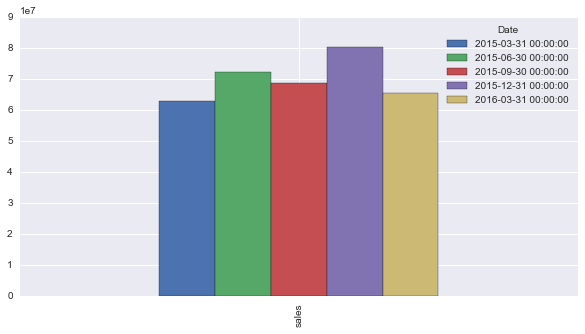

In [9]:
df2 = df1.groupby(pd.TimeGrouper(freq='Q')).sum().T
df2.plot(kind='bar',figsize=(10,5))
print '\n                          Quarterly Sales - 2015'
print '                          Q1-2015:  ', '{:,}'.format(round(Q1_2015.sum(), 2))
print '                          Q2-2015:  ', '{:,}'.format(round(Q2_2015.sum(), 2))
print '                          Q3-2015:  ', '{:,}'.format(round(Q3_2015.sum(), 2))
print '                          Q4-2015:  ', '{:,}'.format(round(Q4_2015.sum(), 2))
print '\n                          Quarterly Sales - 2016'
print '                          Q1-2016:  ', '{:,}'.format(round(Q1_2016.sum(), 2))

##### Visualize Monthly Sales


          Monthly Sales from January-2015 through March 2016


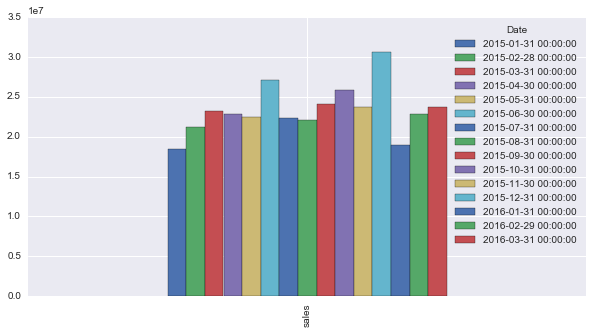

In [10]:
df2 = df1.groupby(pd.TimeGrouper(freq='M')).sum().T
df2.plot(kind='bar',figsize=(10,5))
print '\n          Monthly Sales from January-2015 through March 2016'

In [11]:
df2.T

,sales
Date,
2015-01-31,18498508.31
2015-02-28,21224352.41
2015-03-31,23262369.71
2015-04-30,22857263.33
2015-05-31,22437370.96
2015-06-30,27089683.13
2015-07-31,22414165.50
2015-08-31,22116397.55
2015-09-30,24113360.17


##### Visualize Weekly Sales


                                                     Weekly Sales
                                            from Jan-2015 through Mar-2016


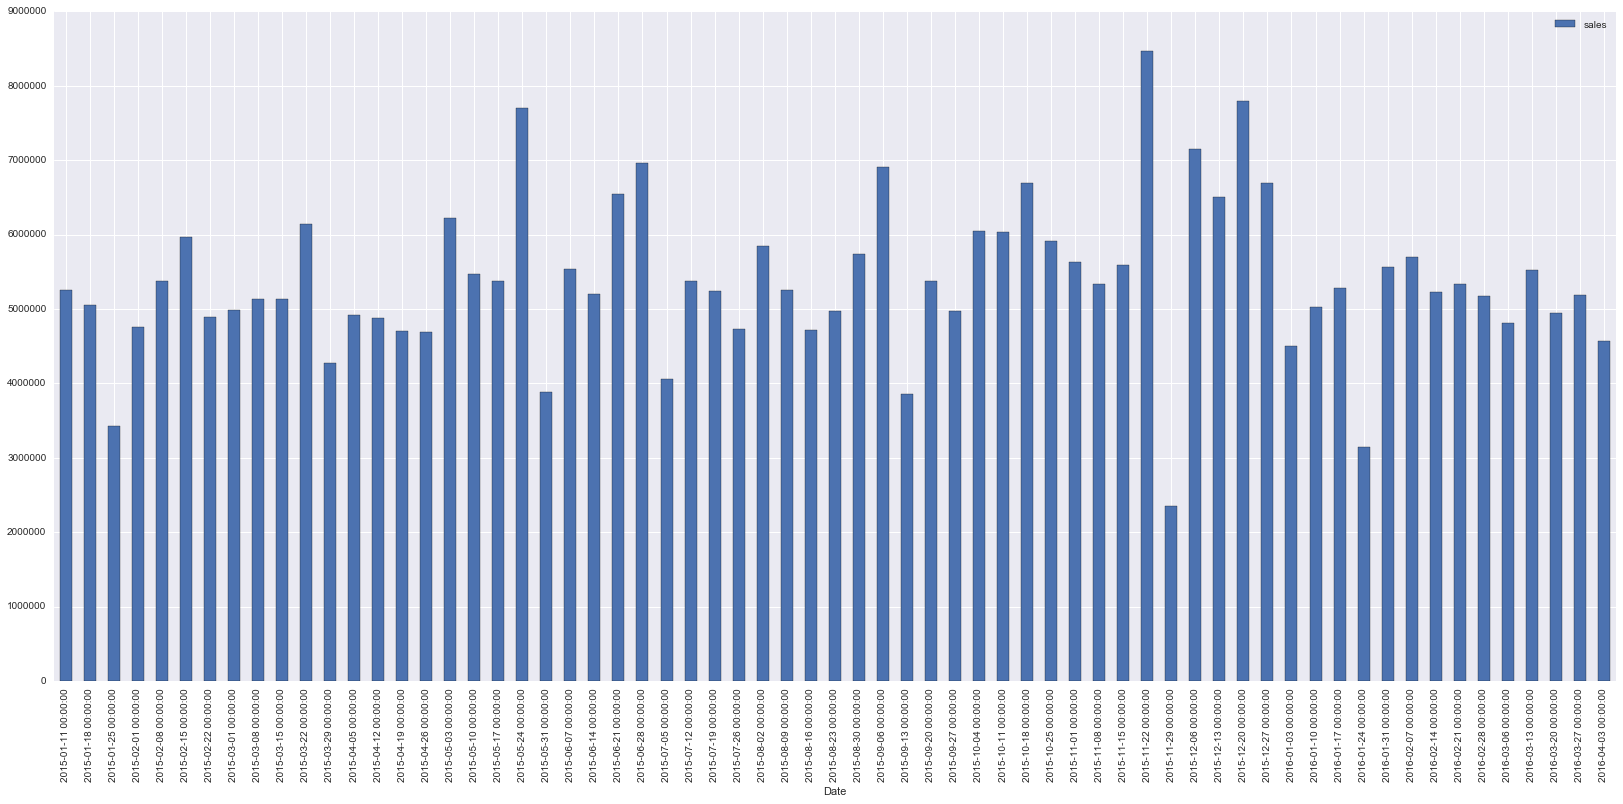

In [12]:
df2 = df1.groupby(pd.TimeGrouper(freq='W')).sum()
df2.plot(kind='bar', figsize=(28,12))
print '\n                                                     Weekly Sales'
print '                                            from Jan-2015 through Mar-2016'

##### Check Stationarity

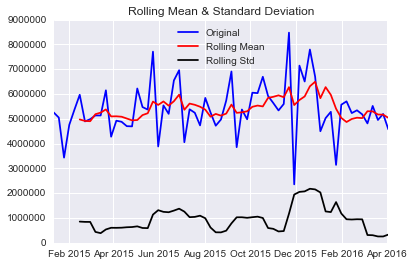


Although the mean has not changed over time, it has not been constant during each
period, so differentiation may be required in the ARIMA model.


In [14]:
def test_stationarity(ts):
    #plot rolling statistics
    rolmean = ts.rolling(window=6,center=False).mean()
    rolstd = ts.rolling(window=6,center=False).std()
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
time_series = df2['sales']  # use weekly sales for testing stationarity
test_stationarity(time_series)
print '\nAlthough the mean has not changed over time, it has not been constant during each' 
print 'period, so differentiation may be required in the ARIMA model.' 

##### Check Autocorrelation & Partial Autocorrelation

In [15]:
df2 = df1.groupby(pd.TimeGrouper(freq='Q')).sum()
time_series = df2['sales'] # use quarterly sales for model building
lags = range(5)
auto_corr = acf(time_series, nlags=4)
partial_corr = pacf(time_series, nlags=4)
df_corr = pd.DataFrame(zip(lags, auto_corr, partial_corr), 
                       columns=['LAGS', 'ACF', 'PCF'])
print df_corr.to_string(index=False)
print '\nSome minimal correlation in time implies an AR model can be useful.'
print 'No significant spikes imply that a MA model may not be useful.'

LAGS       ACF       PCF
   0  1.000000  1.000000
   1 -0.435536 -0.544420
   2  0.219134  0.097826
   3 -0.453135 -1.291762
   4  0.169536  0.156317

Some minimal correlation in time implies an AR model can be useful.
No significant spikes imply that a MA model may not be useful.


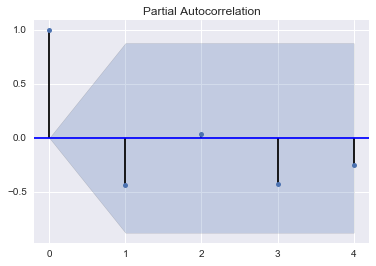

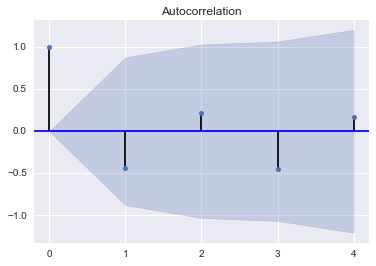

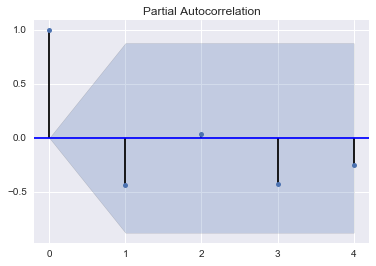

In [16]:
plot_acf(time_series, lags=4)
plot_pacf(time_series, lags=4)

##### Survey AIC/BIC for a Range of ARIMA Models

In [17]:
print 'p', 'd', 'q', '    AIC','              BIC' 
for p in range(1, 5):
    for d in range(2):
        for q in range(2):
            try:
                modl=ARIMA(time_series,(p,d,q)).fit()
                print p, d, q, '   ', modl.aic, '   ', modl.bic
            except:
                pass

p d q     AIC               BIC
1 0 0     174.994557205     173.822870942
1 1 0     162.446208159     160.605091243
2 0 0     176.726023488     175.163775137


##### ARIMA(1,1,0) model

In [18]:
modl=ARIMA(time_series,(1,1,0)).fit()
modl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                    4
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -78.223
Method:                       css-mle   S.D. of innovations        4551646.496
Date:                Sat, 15 Oct 2016   AIC                            162.446
Time:                        02:36:07   BIC                            160.605
Sample:                    06-30-2015   HQIC                           158.406
                         - 03-31-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          6.353e+05        nan        nan        nan           nan       nan
ar.L1.D.sales    -1.0000        nan        nan        nan           nan       nan
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

##### Forecast

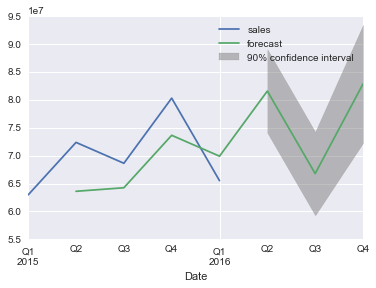

In [24]:
fig, ax = plt.subplots()
ax = time_series.plot(ax=ax)
fig = modl.plot_predict(1, 7, ax=ax, plot_insample=False, alpha=0.1)

Quarterly Sales
<br>Q1-2015: 63.0 million (actual)  -  Q1-2016: 65.5 million (actual)
<br>Q2-2015: 72.4 million (actual)  -  Q2-2016: 82 million (forecast)
<br>Q3-2015: 68.6 million (actual)  -  Q3-2016: 67 million (forecast)
<br>Q4-2015: 80.3 million (actual)  -  Q4-2016: 83 million (forecast) 

##### Plot Autocorrelation of the Residuals

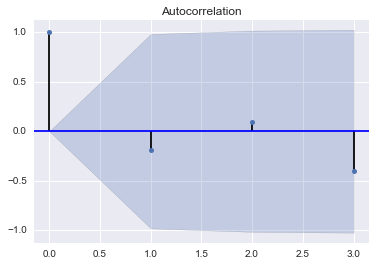

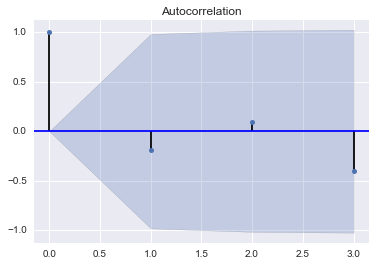

In [26]:
plot_acf(modl.resid, lags=3)